# ST446-Final-Project-BigData Regression on PySpark

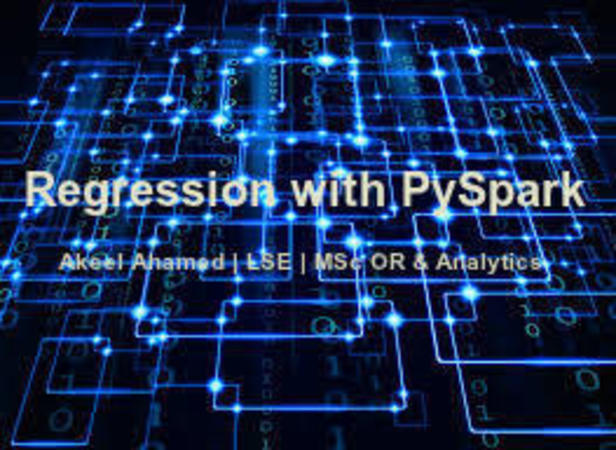

In [181]:
from IPython.display import Image
Image(filename = "/Users/akeelahamed/Desktop/BigData.jpg")

# Abstract
This notebook aims to leverage the regression functionality of Spark's MLLib package to highlight the outcome of regressing `Median Household Value` on several other regressors from the California Housing Dataset (containing over 20,000 records). Some Data preprocessing including Standardisation and feature extraction have also been performed in order to build a stronger model for predicting the response. 

We then split the dataset into an 80:20 split for training and testing and evaluated it on various regression algorithms to see which algorithm gives the best possible prediction/ least error. For completeness, an introduction to Bayesian Linear Regression has also been given although the dataset was not tested using this method.
The notebook is setup locally on a single node(computer) using Apache Spark.

# 1.  Introduction
Apache Spark is a fast and general purpose cluster computing platform for big data processing that has built-in modules for streaming, SQL, Machine Learning (ML) and graph processing. 
This section of the Notebook focuses on applying various Regression Algorithms using Sparks MLLib package on the California Housing Dataset (available for download at http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). Each row in the dataset contains information about a Block Group in California from the 1990 Census. A block group is "the smallest geographical unit for which the Census bureau publishes sample data, i.e. data which is only collected from a fraction of all households" (Source: Wikipedia). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.<br> 

All blocks reporting zero entries for the independent and dependant variables have been excluded. This means there aren't any missing values. There are 20,460 cases of 9 variables:
- **Longitude** refers to the angular distance of a geographic place north or south of the earth’s equator for each block group. <br>
- **Latitude** refers to the angular distance of a geographic place east or west of the earth’s equator for each block group. <br>
- **Housing median age** is the median age of the people that belong to a block group. <br>
- **Total rooms** is the total number of rooms in the houses per block group. <br>
- **Total bedrooms** is the total number of bedrooms in the houses per block group. <br>
- **Population** is the number of inhabitants of a block group. <br>
- **Households** refers to units of houses and their occupants per block group. <br>
- **Median income** is used to register the median income of people that belong to a block group.
- **Median house value** is the dependent variable and refers to the median house value per block group. <br>

We will try to use Regression to infer the Median house value based on the other predictors. This will help us answer questions such as 

This Notebook will also apply **Bayesian Linear Regression** on the IMDB Movies 5000 dataset (from https://www.kaggle.com/rounakbanik/the-movies-dataset/data) which contains metadata on over 45,000 movies. <br>

The approach along with the notation behind Bayesian Regression will closely follow the book [Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738/ref=sr_1_1?ie=UTF8&qid=1474908936&sr=8-1&keywords=pattern+recognition+and+machine+learning).

# 2. Data Preprocessing & Analysis


## 2.1 Load Relevant Packages

In [232]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Setting SQLContext for Spark SQL Functionality
sqlContext = SQLContext(sc)

## 2.2 Load & Clean Data

In [233]:
# Housing Data Files
# Housing Data
housing_data = sc.textFile("/Users/akeelahamed/Desktop/ST446_Final_Proj/CaliforniaHousing/cal_housing.data")
# Domain Data file containing Headers in order to double check Variables during Preprocessing
header = sc.textFile("/Users/akeelahamed/Desktop/ST446_Final_Proj/CaliforniaHousing/cal_housing.domain")

Since Spark Loads RDDs in a "lazy" manner, the data is only computed the first time it is used in an action. Thus, in order to be able to reuse the dataframe, we need to persist/cache it using persist():

In [234]:
housing_data.persist()
header.persist()

/Users/akeelahamed/Desktop/ST446_Final_Proj/CaliforniaHousing/cal_housing.domain MapPartitionsRDD[12899] at textFile at NativeMethodAccessorImpl.java:0

We load in data using Sparks concept of an RDD (Resilient Distributed Dataset). An RDD is an immutable distributed collection of objects. Each rdd can be split into multiple partitions which may be computed on different nodes of the cluster (a group of computers with atleast one master computer). Since our dataset is relatively small, there won't be a need to partition the data into different clusters.

In [235]:
# The take() action/method prints the first few elements of an RDD and thus is relatively 
# as compared to collect().
#Inspect the first two rows
housing_data.take(2)

['-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000',
 '-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000']

In [236]:
# Collect() reads in all the elements of the RDD.
header.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [237]:
#Converting Data into a Dataframe
housing_data = housing_data.map(lambda line: line.split(","))

housing_data.take(2)

[['-122.230000',
  '37.880000',
  '41.000000',
  '880.000000',
  '129.000000',
  '322.000000',
  '126.000000',
  '8.325200',
  '452600.000000'],
 ['-122.220000',
  '37.860000',
  '21.000000',
  '7099.000000',
  '1106.000000',
  '2401.000000',
  '1138.000000',
  '8.301400',
  '358500.000000']]

In [238]:
#Mapping the RDD to a Dataframe
from pyspark.sql import Row

housing_df = housing_data.map(lambda line: Row(longitude=line[0], 
                              latitude=line[1], 
                              housingMedianAge=line[2],
                              totalRooms=line[3],
                              totalBedRooms=line[4],
                              population=line[5], 
                              households=line[6],
                              medianIncome=line[7],
                              medianHouseValue=line[8])).toDF()

In [239]:
housing_df.persist()

DataFrame[households: string, housingMedianAge: string, latitude: string, longitude: string, medianHouseValue: string, medianIncome: string, population: string, totalBedRooms: string, totalRooms: string]

In [240]:
housing_df.show()

+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| households|housingMedianAge| latitude|  longitude|medianHouseValue|medianIncome| population|totalBedRooms| totalRooms|
+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| 126.000000|       41.000000|37.880000|-122.230000|   452600.000000|    8.325200| 322.000000|   129.000000| 880.000000|
|1138.000000|       21.000000|37.860000|-122.220000|   358500.000000|    8.301400|2401.000000|  1106.000000|7099.000000|
| 177.000000|       52.000000|37.850000|-122.240000|   352100.000000|    7.257400| 496.000000|   190.000000|1467.000000|
| 219.000000|       52.000000|37.850000|-122.250000|   341300.000000|    5.643100| 558.000000|   235.000000|1274.000000|
| 259.000000|       52.000000|37.850000|-122.250000|   342200.000000|    3.846200| 565.000000|   280.000000|1627.000000|
| 193.000000|       52.000000|37

In [241]:
housing_df.printSchema()

root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



Since the datatypes are all strings, we need to convert them to numeric; in Python, we use the **FloatType()** cast.

In [242]:
from pyspark.sql.types import *

def colconverter(df,colnames, NewType):
    for name in colnames:
        df = df.withColumn(name, df[name].cast(NewType))
    return df

#Column names vector
colnames = ['households', 'housingMedianAge', 'latitude', 'longitude', 'medianHouseValue', 'medianIncome', 'population', 'totalBedRooms', 'totalRooms']

housing_df = colconverter(housing_df, colnames, FloatType())

In [243]:
#Once again inspecting schema 
#housing_df.printSchema()

## 2.3 Exploratory Analysis & Visualisation

In [244]:
#Summary Statistics: 
# Count , mean, min and max
housing_df.describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|        households|  housingMedianAge|          latitude|          longitude|  medianHouseValue|      medianIncome|        population|    totalBedRooms|        totalRooms|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             20640|             20640|             20640|              20640|             20640|             20640|             20640|            20640|             20640|
|   mean| 499.5396802325581|28.639486434108527| 35.63186143109965|-119.56970444871473|206855.81690891474|3.8706710030346416|1425.4767441860465|537.8980135658915|2635.7630813953488|
| stddev|382.32975283161136|12.585557612111613|2.1359523806029554| 2.0035317429328914|115395.61

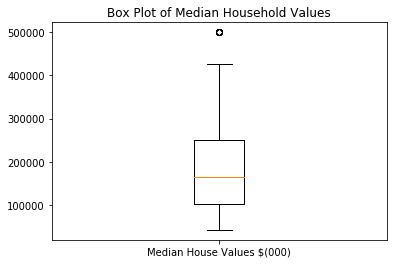

In [245]:
# Creating a temporary table of the dataset in order to perform SQL Operations and draw Graphs
housing_df.createOrReplaceTempView("housing")
# Creating Statistical Plots
from pylab import *
#Note for large datasets (typically >1GB), we will have a lot of missing values in cells. Thus,
# to exclude them when running the below command, we can add "FROM housing where housing is not 
# null".
# Furthermore, we can also use the sample function to randomly sample a few datapoints for 
# analysis. This is less expensive than running the function on the entire dataset.
plot1 = spark.sql("SELECT medianHouseValue FROM housing")
plot1_array = plot1.rdd.map(lambda row: row.medianHouseValue).sample(False, 0.01).collect()
plt.boxplot(plot1_array,labels=["Median House Values $(000)"]);plt.title("Box Plot of Median Household Values"); plt.show()

The box plot shows that the mean household value(shown by the yellow line) iis around $150,000$, the range is between $20000$ to $500000$ (which is an outlier). Thus, there is a great deal of variability amongst the predictor variables.

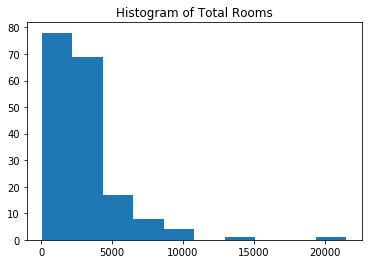

In [246]:
plot2 = spark.sql("SELECT totalRooms FROM housing")
plot2_array = plot2.rdd.map(lambda row: row.totalRooms).sample(False, 0.01).collect()
plt.hist(plot2_array,label=["Total Rooms in a Block Group"]);plt.title("Histogram of Total Rooms"); plt.show()

The histogram shows a positively skewed distribution of total Rooms in a block group with the majority of blocks having between 400-5000 rooms respectively.



In [247]:
housing_df.stat.corr("totalBedRooms", "totalRooms")

0.9298933480131929

In [248]:
housing_df.stat.corr("medianIncome", "housingMedianAge")

-0.11903398979621561

In [249]:
housing_df.stat.corr("medianHouseValue", "totalRooms")

0.1341531138065622

## 2.4 Data Preprocessing & Feature Selection

### Feature Selection
At this point, we will exclude the variables which wouldnt be helpful in predicting the Median House Value such as latitude & longitude. In order to reduce multicollinearity we will also remove one of the variables "totalRooms" or "totalBedRooms". Correlation with the response indicates that the "totalBedRooms" variable has a lower correlation thus we will exlude this too.  

In [250]:
housing_df = housing_df.drop("latitude", "longitude", "totalBedRooms")
housing_df.printSchema()

root
 |-- households: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- population: float (nullable = true)
 |-- totalRooms: float (nullable = true)



We can also add new a feature that may be helpful in predicting the response such as number of rooms per household.

In [251]:
housing_df = housing_df.withColumn("householdRooms", col("totalRooms")/\
                                  col("households"))
housing_df.printSchema()

root
 |-- households: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- population: float (nullable = true)
 |-- totalRooms: float (nullable = true)
 |-- householdRooms: double (nullable = true)



### Standardisation of Predictors
As will be shown below, the range of values of the predictor variables vary greatly. 
This can lead to misclassification of the Response. Thus, we will standardise (subtract mean & divide by standard deviation) the predictors for equal comparability in analysis.


In [200]:
housing_df.select("medianHouseValue", "Households", "population", "totalRooms",\
                  "householdRooms").show()

+----------------+----------+----------+----------+------------------+
|medianHouseValue|Households|population|totalRooms|    householdRooms|
+----------------+----------+----------+----------+------------------+
|        452600.0|     126.0|     322.0|     880.0| 6.984126984126984|
|        358500.0|    1138.0|    2401.0|    7099.0| 6.238137082601054|
|        352100.0|     177.0|     496.0|    1467.0| 8.288135593220339|
|        341300.0|     219.0|     558.0|    1274.0|5.8173515981735155|
|        342200.0|     259.0|     565.0|    1627.0| 6.281853281853282|
|        269700.0|     193.0|     413.0|     919.0| 4.761658031088083|
|        299200.0|     514.0|    1094.0|    2535.0|4.9319066147859925|
|        241400.0|     647.0|    1157.0|    3104.0| 4.797527047913447|
|        226700.0|     595.0|    1206.0|    2555.0| 4.294117647058823|
|        261100.0|     714.0|    1551.0|    3549.0| 4.970588235294118|
|        281500.0|     402.0|     910.0|    2202.0| 5.477611940298507|
|     

In [252]:
from pyspark.sql.functions import *

# Adjust the values of `medianHouseValue` to be in units of 100000
housing_df = housing_df.withColumn("medianHouseValue", col("medianHouseValue")/100000)

# Show the first 2 lines of `df`
housing_df.take(2)

[Row(households=126.0, housingMedianAge=41.0, medianHouseValue=4.526, medianIncome=8.325200080871582, population=322.0, totalRooms=880.0, householdRooms=6.984126984126984),
 Row(households=1138.0, housingMedianAge=21.0, medianHouseValue=3.585, medianIncome=8.301400184631348, population=2401.0, totalRooms=7099.0, householdRooms=6.238137082601054)]

In [253]:
# Re-order and select columns
housing_df = housing_df.select("medianHouseValue",  
              "population", 
              "households", 
              "medianIncome", 
              "totalRooms", 
              "housingMedianAge",
              "householdRooms")

In [255]:
# Import `DenseVector` which stores arrays of values for use in PySpark.
from pyspark.ml.linalg import DenseVector

# Define the `input_data` 
input_data = housing_df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

# Replace `df` with the new DataFrame
housing_df = spark.createDataFrame(input_data, ["label", "features"])

In [256]:
# Import `StandardScaler` to scale data
from pyspark.ml.feature import StandardScaler

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(housing_df)

# Transform the data in `df` with the scaler
scaled_housing_df = scaler.transform(housing_df)

# Inspect the result
scaled_housing_df.take(2)

[Row(label=4.526, features=DenseVector([322.0, 126.0, 8.3252, 880.0, 41.0, 6.9841]), features_scaled=DenseVector([0.2843, 0.3296, 4.3821, 0.4034, 3.2577, 2.8228])),
 Row(label=3.585, features=DenseVector([2401.0, 1138.0, 8.3014, 7099.0, 21.0, 6.2381]), features_scaled=DenseVector([2.1202, 2.9765, 4.3696, 3.254, 1.6686, 2.5213]))]

# 3. Linear Regression with Spark MLLib

## 3.1 Multivariate Linear Regression

In [257]:
# Split the housing data into train and test sets
train_set, test_set = scaled_housing_df.randomSplit([.8,.2],seed=6007)

In [258]:
train_set.count()
#test_set.count()

16606

In [259]:
from pyspark.ml.regression import LinearRegression
import time
start = time.time()
lr = LinearRegression(featuresCol='features_scaled',maxIter=100, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_set)

# Generate predictions
predictions = lrModel.transform(test_set)

predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

end = time.time()
print("This algorithm ran in %.3f seconds" %(end - start))

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|1.2381206691657132| 0.25|[64.0,27.0,0.8571...|
|  2.10919801047237|0.325|[51.0,20.0,4.0208...|
|1.3179678062093794|0.329|[436.0,213.0,1.14...|
|1.5929449013331725|0.344|[530.0,115.0,2.14...|
|1.4269453943383064|0.394|[677.0,213.0,1.54...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.866878
This algorithm ran in 3.351 seconds


In [208]:
# Generate predictions
predicted = lrModel.transform(test_set)

# Extract the predictions and the "known" correct labels
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

# Zip `predictions` and `labels` into a list
predictionAndLabel = predictions.zip(labels).collect()

# Print out first 5 instances of `predictionAndLabel` 
predictionAndLabel[:5]

[(1.2381206691657132, 0.25),
 (2.10919801047237, 0.325),
 (1.3179678062093794, 0.329),
 (1.5929449013331725, 0.344),
 (1.4269453943383064, 0.394)]

## 3.2 Decision Tree Regression

In [209]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(scaled_housing_df)

start = time.time()
# Split the housing data into train and test sets with same seed for comparison
train_set, test_set = scaled_housing_df.randomSplit([.8,.2],seed=6007)

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="features_scaled")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(train_set)

# Make predictions.
predictions = model.transform(test_set)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)
end = time.time()
print("This algorithm ran in %.3f seconds" %(end - start))


+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|1.6802365255731917| 0.25|[64.0,27.0,0.8571...|
|2.0503728839981656|0.325|[51.0,20.0,4.0208...|
|0.9556517616279071|0.329|[436.0,213.0,1.14...|
|1.6802365255731917|0.344|[530.0,115.0,2.14...|
|0.9556517616279071|0.394|[677.0,213.0,1.54...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.741743
DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4c36a4ae69436d6ea4eb) of depth 5 with 63 nodes
This algorithm ran in 3.718 seconds


## 3.3 Random Forest Regression

In [210]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()

# Split the housing data into train and test sets
train_set, test_set = scaled_housing_df.randomSplit([.8,.2],seed=6007)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(scaled_housing_df)

# Split the housing data into train and test sets with same seed for comparison
train_set, test_set = scaled_housing_df.randomSplit([.8,.2],seed=6007)

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures")

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(train_set)

# Make predictions.
predictions = model.transform(test_set)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

end = time.time()
print("This algorithm ran in %.3f seconds" %(end - start))

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|1.4913632865138324| 0.25|[64.0,27.0,0.8571...|
|1.8288912846309493|0.325|[51.0,20.0,4.0208...|
|1.3318581450617952|0.329|[436.0,213.0,1.14...|
|1.5010005189023636|0.344|[530.0,115.0,2.14...|
|1.3638880921079373|0.394|[677.0,213.0,1.54...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.764274
RandomForestRegressionModel (uid=RandomForestRegressor_4c8988d21a02210d3fa1) with 20 trees
This algorithm ran in 3.716 seconds


## 3.4 Gradient-boosted tree regression

In [260]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(scaled_housing_df)

start = time.time()
# Split the housing data into train and test sets with same seed for comparison
train_set, test_set = scaled_housing_df.randomSplit([.8,.2],seed=6007)

# Train a GBT model.
gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=10)

# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, gbt])

# Train model.  This also runs the indexer.
model = pipeline.fit(train_set)

# Make predictions.
predictions = model.transform(test_set)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbtModel = model.stages[1]
print(gbtModel)  # summary only

end = time.time()
print("This algorithm ran in %.3f seconds" %(end - start))

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|1.6814406896283263| 0.25|[64.0,27.0,0.8571...|
|1.8156257234134694|0.325|[51.0,20.0,4.0208...|
|  0.86138917874328|0.329|[436.0,213.0,1.14...|
| 1.722491371700923|0.344|[530.0,115.0,2.14...|
|0.8055579284479044|0.394|[677.0,213.0,1.54...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.689265
GBTRegressionModel (uid=GBTRegressor_46f1b6c60efcde1e121e) with 10 trees
This algorithm ran in 7.154 seconds


# 3.5 Bayesian Linear Regression Intro
This section gives a brief overview of BLR with the notation closely following that of the book Pattern Recognition and Machine Learning.
## Background
Bayesian Linear Regression (BLR) has the same general model of linear regression except that the response is now characterised by a probability distribution rather than a single point estimate. This is more powerful than just assigning a single-valued estimate of $t$ like traditional Linear Regression, because probability helps us to judge model uncertainty. If we needed a value to t, we can take the maximum of this probability distribution.
Assume the response/target variable $t$ is given by some function of the inputs/parameters and a noise term.

$$t = f(\vec{x}, \vec{w}) + \epsilon $$

Let's assume the noise is characterized by a normal distribution of mean 0 and precision(inverse variance) $\beta$.  Therefore we can say the probability of a value $t$ is given by a normal distribution around the value of the function $f(\vec{x}, \vec{w})$ at that point:

$$p(t \mid \vec{x}, \vec{w}) = Norm(t \mid f(\vec{x}, \vec{w}), \beta^{-1}) \tag{1}$$ 

where $Norm(t \mid \mu, \sigma^2)$ represents a normal distribution of mean $\mu$ and variance $\sigma^2$.

We want to predict $t$ for a new input $\vec{x}$ given some old data $D$ to base that prediction on: 

$$p(t \mid \vec{x}, D)$$


### The Model
Let's assume a model for this target that's linear in the parameters $\{w_j\}$, but has a general basis representation of the inputs given by $\{\phi_j(\vec{x})\}$.  This results in the following model form:
$$y(\vec{x}, \vec{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\vec{x})$$ 
where M is the total number of model parameters.

Note that the basis functions $\phi_j(\vec{x})$ do *not* need to be linear in $\vec{x}$; the linearity required in the assumptions is in reference to the parameters $\{w_j\}$.  We could therefore have, e.g. $\phi_n(x) = sin(nx)$.

For convenience, let's define the basis function $\phi_0(\vec{x}) \equiv 1$ so that we can write the model as a vector equation: 

$$y(\vec{x}, \vec{w}) = \vec{w}^T \vec{\phi}(\vec{x})$$

where $\vec{\phi} = (\phi_0, ..., \phi_{M-1})^T$ and $\vec{w} = (w_0, ..., w_{M-1})^T$

Therefore our model of the target $t$ is given by:

$$p(t \mid \vec{x}, \vec{w}) =  Norm(t \mid y(\vec{x}, \vec{w}), \beta^{-1}) = Norm(t \mid \vec{w}^T \vec{\phi}(\vec{x}), \beta^{-1}) \tag{2}$$ 

and we hope, among other things, to find values for $\vec{w}$ that make a good fit to the true model, given by $(1)$.

### Example Case
Let's say the true function (which will be unknown to our analysis) is given by 

$$ f(x, \vec{a}) = a_0 + a_1x + \epsilon \tag{A}$$ 

with noise $\epsilon$ given by

$$\epsilon = Norm(n \mid 0, \beta^{-1}) \tag{B}$$


where 
$$a_0 = {-0.3} \\
a_1 = 0.5 \\
\beta = \frac{1}{0.2^2}$$

We generate observational data by sampling input $x$ from a uniform distribution $ U(x \mid -1, 1)$, generating noise $\epsilon$ by sampling from $(B)$, and then evaluating $(A)$ to get our target $t$.  This gives us our dataset $\{\vec{X}, \vec{t}\}$.


For our Bayesian analysis we'll start with a simple prior that has means of zero and assumes the precisions are isotropic and governed by a single precision parameter $\alpha$:
$$ p(\vec{w} \mid \alpha) = Norm(\vec{w} \mid \vec{0}, \alpha^{-1}\vec{I}) $$

Our posterior updates evaluate to:
$$ \vec{S}^{-1}_N = \alpha\vec{I} + \beta\vec{\Phi}^T\vec{\Phi} $$
$$ \vec{m}_N = \beta\vec{S}_N\vec{\Phi}^T\vec{t} $$

Recall that in this case, we're assuming that the noise precision of $\beta$ is known to us.

In [7]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt
%matplotlib inline

#### Coding up the real function as in 7.1

In [8]:
def real_function(a_0, a_1, noise_sigma, x):
    """
    Evaluates the real function
    """
    N = len(x)
    if noise_sigma==0:
        # Recovers the true function
        return a_0 + a_1*x
    else:
        return a_0 + a_1*x + normal(0, noise_sigma, N)

We then define a class that will perform the parameter updates. Note that the only inputs are the priors mean , covariance and the assumed noise prediction parameter $\beta$. (**Note**: Code has been imported from https://github.com/zjost/bayesian-linear-regression).

In [3]:
class LinearBayes(object):
    """
    A class that holds parameter prior/posterior and handles 
    the hyper-parameter updates with new data
    
    Note:  variables starting with "v_" indicate Nx1 dimensional 
        column vectors, those starting with "m_" indicate 
        matrices, and those starting with "a_" indicate 
        1xN dimensional arrays.
    
    Args:
        a_m0 (np.array): prior mean vector of size 1xM
        m_S0 (np.ndarray): prior covariance matrix of size MxM
        beta (float): known real-data noise precision
        
    """
    def __init__(self, a_m0, m_S0, beta):
        self.prior = mv_norm(mean=a_m0, cov=m_S0)
        self.v_m0 = a_m0.reshape(a_m0.shape + (1,)) #reshape to column vector
        self.m_S0 = m_S0
        self.beta = beta
        
        self.v_mN = self.v_m0
        self.m_SN = self.m_S0
        self.posterior = self.prior
           
    def get_phi(self, a_x):
        """
        Returns the design matrix of size (NxM) for a feature vector v_x.
        In this case, this function merely adds the phi_0 dummy basis
        that's equal to 1 for all elements.
        
        Args:
            a_x (np.array): input features of size 1xN
        """
        m_phi = np.ones((len(a_x), 2))
        m_phi[:, 1] = a_x
        return m_phi
        
    def set_posterior(self, a_x, a_t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        # Need to convert v_t from an array into a column vector
        # to correctly compute matrix multiplication
        v_t = a_t.reshape(a_t.shape + (1,))

        m_phi = self.get_phi(a_x)
        
        self.m_SN = np.linalg.inv(np.linalg.inv(self.m_S0) + self.beta*m_phi.T.dot(m_phi))
        self.v_mN = self.m_SN.dot(np.linalg.inv(self.m_S0).dot(self.v_m0) + \
                                      self.beta*m_phi.T.dot(v_t))
        
        self.posterior = mv_norm(mean=self.v_mN.flatten(), cov=self.m_SN)

    
    def prediction_limit(self, a_x, stdevs):
        """
        Calculates the limit that's "stdevs" standard deviations
        away from the mean at a given value of x.
        
        Args:
            a_x (np.array): x-axis values of size 1xN
            stdevs (float): Number of standard deviations away from
                the mean to calculate the prediction limit
        
        Returns:
            np.array: the prediction limit "stdevs" standard deviations
                away from the mean corresponding to x-values in "v_x"
        
        """
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append((mean_x+stdevs*np.sqrt(sig_sq_x)).flatten())
        return np.concatenate(predictions)
    
    def generate_data(self, a_x):
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append(normal(mean_x.flatten(), np.sqrt(sig_sq_x)))
        return np.array(predictions)
    
    def make_contour(self, a_x, a_y, real_parms=[], N=0):
        """
        A helper function to generate contour plots of our probability distribution
        """
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
            
        _ = plt.title('Distribution for Weight Parameters using %d datapoint(s)' % N, fontsize=10)
    
    def make_scatter(self, a_x, a_t, real_parms, samples=None, stdevs=None):
        """
        A helper function to plot noisey data, the true function, 
        and optionally a set of lines specified by the nested array of
        weights of size NxM where N is number of lines, M is 2 for 
        this simple model
        """
        plt.scatter(a_x, a_t, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('t')

        plt.plot([-1, 1], real_function(real_parms[0], real_parms[1], 0, np.array([-1., 1.])), 'r')

        _ = plt.title('Real Data from Noisey Linear Function')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], real_function(weight[0], weight[1], 0, np.array([-1., 1.])), 'black')
                _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')
                
        if stdevs:
            a_xrange = np.linspace(-1, 1, 100)
            y_upper = self.prediction_limit(a_xrange, stdevs)
            y_lower = self.prediction_limit(a_xrange, -stdevs)
            plt.plot(a_xrange, y_upper, '+', c='green', linewidth=4.0)
            plt.plot(a_xrange, y_lower, '+', c='green', linewidth=4.0)
            _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')

In [4]:
# Real function parameters
a_0 = -0.3
a_1 = 0.5
noise_sigma = 0.2
beta = 1/noise_sigma**2
# Generate input features from IMDb Data
 # Set the seed so we can get reproducible results
x_real = uniform(-1, 1, 10000000)
# Evaluate the real function for training example inputs
t_real = real_function(a_0, a_1, noise_sigma, x_real)

Now let's set up our prior distribution. We need to assign hyper-parameters that represent the prior's mean and covariance. We said above that we'll assume an isotropic gaussian, which means the covariance will be constant and the same in all directions. Let's choose a precision of $\alpha = 2.0$. Our covariance is then the inverse of this value multiplied by the identity matrix. We then instantiate an instance of our helper LinearBayes class defined above.

In [5]:
alpha = 2.0
v_m0 = np.array([0., 0.])
m_S0 = 1/alpha*np.identity(2)

linbayes = LinearBayes(v_m0, m_S0, beta)

Our real, noisey data is shown below as the blue dots. The "true" function parameters we're trying to find are represented by the red line function.

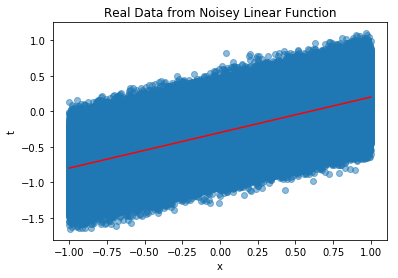

In [6]:
linbayes.make_scatter(x_real, t_real, real_parms = [a_0, a_1])

Let's take a look at the prior distribution. The real values for the true parameters ($a_0=-0.3, a_1=0.5$) are represented as a black tick mark. Note that our prior distribution is centered at $(0, 0)$ and assigns relatively low, but non-zero probability to where the true parameter values lie. The cooler colours like **blue** represent lower values while the warmer colours like **orange** and **yellow** represent higher values. 

In [ ]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=0)

In [ ]:
# Take a single point from data to see how it compares to the true function
N=1
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

Now let's use this data point to update our estimation of the red line. 
We'll do this by updating the $ \{\vec{m}_N, \vec{S}_N\}$ parameters according to our formulae above, and plot the posterior distribution for the model parameters.

Note that these upper/lower bounds are closest together around the one data point we used.

Now let's try adding 10 data points.

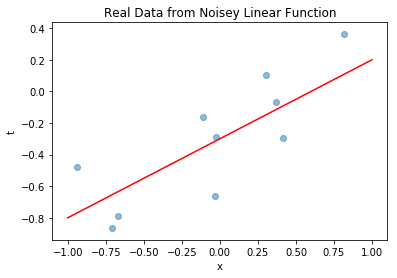

In [19]:
N=10
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

Here's the posterior distribution for the weights using both data points

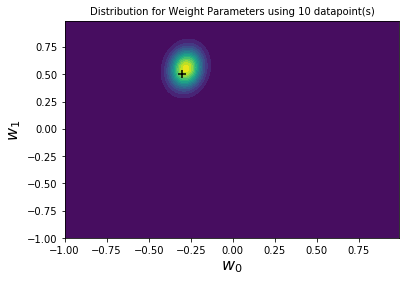

In [20]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

Let's pull some samples from this distribution to generate some example estimates and include the 1-standard deviation confidence intervals.

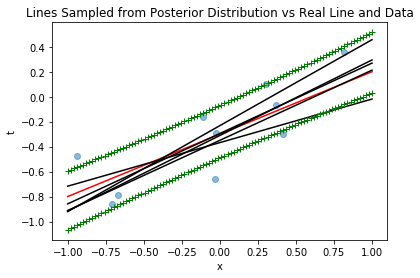

In [21]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

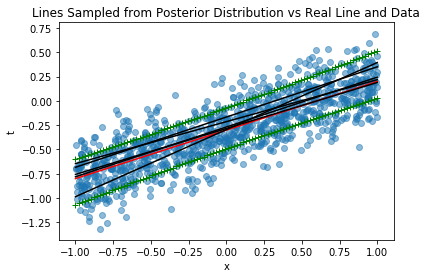

In [22]:
N=1000
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

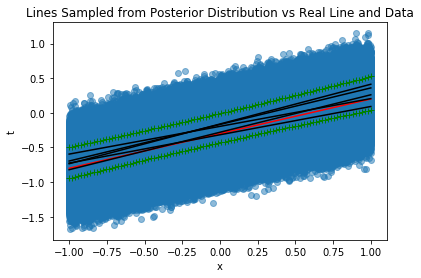

In [27]:
#Whole Dataset
N=10000000
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

This algorithm ran in 0.336 seconds


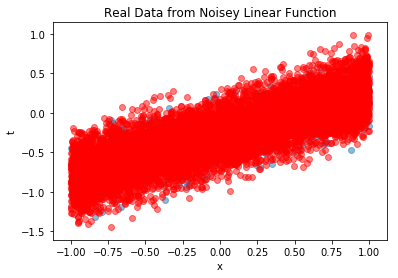

In [36]:
import time
start=time.time()
a_x = np.linspace(-1, 1, 1000)
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])
_ = plt.scatter(a_x, linbayes.generate_data(a_x), c='r', alpha=0.5)
end = time.time() 
print("This algorithm ran in %.3f seconds" %(end - start))

# Conclusion

In conclusion, we find that out of the 4 Regression Algorithms tested, Gradient Boosted tree regression worked best with an RSE of 0.64. However, in terms of computation time, it performed the worst with a runtime of nearly 60 seconds(This is because we ran it with 100 trees; if we changed the number to 10 trees, it still performs better with an RSE of 0.689 and a run time of 7.154 seconds).  

# References
- Apache Spark & MLLib https://spark.apache.org/docs/latest/
- Pattern Recognition and Machine Learning Chapter by Christopher Bishop 3.[Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738/ref=sr_1_1?ie=UTF8&qid=1474908936&sr=8-1&keywords=pattern+recognition+and+machine+learning)
- Bayesian Regression Tutorials: https://github.com/zjost/bayesian-linear-regression & https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-1-7d0ad817fca5
- Learning Spark Lightining Fast Data Analysis https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjZx829tuzaAhWEDMAKHY_fC0gQFggpMAA&url=https%3A%2F%2Fwww.amazon.co.uk%2FLearning-Spark-Lightning-Fast-Data-Analysis%2Fdp%2F1449358624&usg=AOvVaw0_vgNbeGc_XN2x_FMk3LUn
- Learning PySpark https://www.google.com/aclk?sa=L&ai=DChcSEwilj53VtuzaAhXFtO0KHZXfBJsYABAEGgJkZw&sig=AOD64_1EPC5Fg_fG-CepbIp31mpzQpNWpA&q=&ved=0ahUKEwj56pbVtuzaAhWRSsAKHay1AiAQ0QwIMg&adurl=